<a href="https://colab.research.google.com/github/rw-everson/ML/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ncq4zjlc
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ncq4zjlc
  Resolved https://github.com/albumentations-team/albumentations to commit cad3441eb3cdbecb8106490a2e09aebb1d8e1682
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

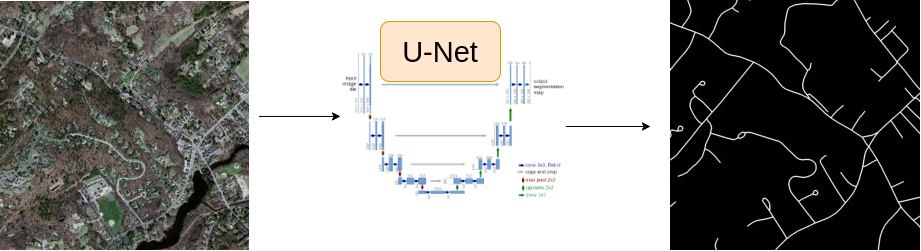

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 26.20 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003 # learning rate
BATCH_SIZE = 8
IMG_SIZE = 512 # original size is 1500x1500

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [9]:
idx = 15
row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) /255


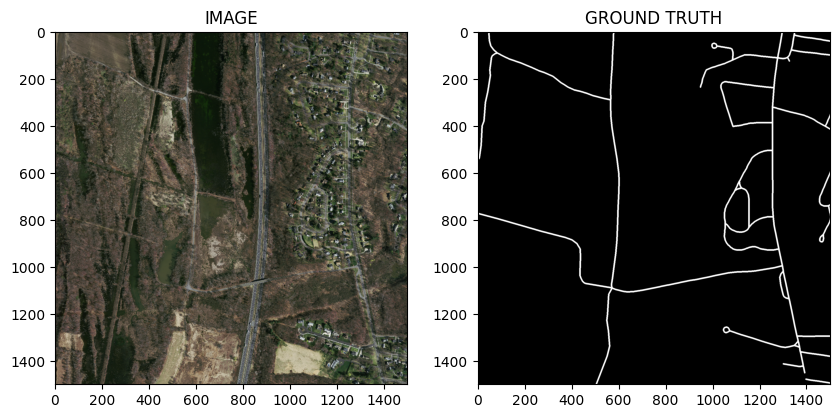

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
len(valid_df)/len(df)

0.20100502512562815

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [15]:
import albumentations as A

In [16]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [17]:
from torch.utils.data import Dataset

In [18]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1) # increase dims to (h,w,c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # pytorch handles images as (channel, h, w) so we need to
    # transpose channel to first dimension
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)/ 255.0)

    return image, mask

In [22]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [20]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


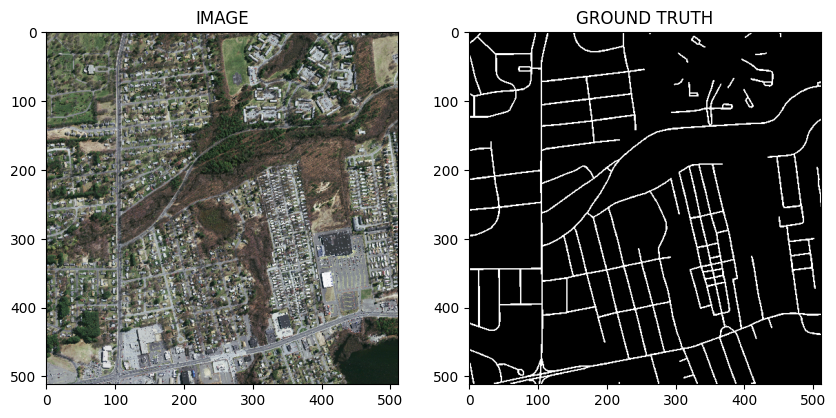

In [27]:
idx = 150

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [28]:
from torch.utils.data import DataLoader

In [29]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [31]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')

Total no. of batches in trainloader : 20
Total no. of batches in validloader : 5


In [33]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask shape: {masks.shape}')
  break

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [34]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [35]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [38]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [39]:
def train_fn(dataloader, model, optimizer):

  model.train() # turn ON dropout, batchnorm, etc.

  total_loss = 0.

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad() #reset the optimizer
    logits, loss = model(images, masks)
    loss.backward() # get the gradients
    optimizer.step() # update the weights

    total_loss += loss.item()

  return total_loss/ len(dataloader)

In [40]:
def eval_fn(dataloader, model):

  model.eval() # turn OFF dropout, batchnorm, etc.

  total_loss = 0.

  with torch.no_grad():

    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss/ len(dataloader)

# Task 8 : Train Model

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [42]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("Saved model.")
    best_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Saved model.
Epoch : 1 Train Loss : 1.0247615814208983 Valid Loss : 1.200727605819702


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Saved model.
Epoch : 2 Train Loss : 0.7778673976659775 Valid Loss : 0.8626935839653015


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Saved model.
Epoch : 3 Train Loss : 0.724513578414917 Valid Loss : 0.6980612516403198


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Saved model.
Epoch : 4 Train Loss : 0.6868244975805282 Valid Loss : 0.6810629010200501


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Saved model.
Epoch : 5 Train Loss : 0.6754753828048706 Valid Loss : 0.6786484122276306


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Saved model.
Epoch : 6 Train Loss : 0.6578088670969009 Valid Loss : 0.6514284491539002


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Saved model.
Epoch : 7 Train Loss : 0.6507936388254165 Valid Loss : 0.6125693798065186


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Epoch : 8 Train Loss : 0.6498504757881165 Valid Loss : 0.6342283129692078


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch : 9 Train Loss : 0.6513938844203949 Valid Loss : 0.6630609393119812


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Saved model.
Epoch : 10 Train Loss : 0.6266839325428009 Valid Loss : 0.5832424759864807


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch : 11 Train Loss : 0.614890706539154 Valid Loss : 0.6255465269088745


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


Epoch : 12 Train Loss : 0.6358121708035469 Valid Loss : 0.7567560315132141


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch : 13 Train Loss : 0.6435570299625397 Valid Loss : 0.6625374913215637


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


Epoch : 14 Train Loss : 0.6217208594083786 Valid Loss : 0.6146602153778076


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Saved model.
Epoch : 15 Train Loss : 0.6144065529108047 Valid Loss : 0.5810310065746307


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch : 16 Train Loss : 0.6262845665216445 Valid Loss : 0.5866379380226135


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch : 17 Train Loss : 0.6039034053683281 Valid Loss : 0.5815091669559479


100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Epoch : 18 Train Loss : 0.5914991080760956 Valid Loss : 0.6182090878486634


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Saved model.
Epoch : 19 Train Loss : 0.5871854439377785 Valid Loss : 0.5775982499122619


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch : 20 Train Loss : 0.5920584052801132 Valid Loss : 0.6175117492675781


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch : 21 Train Loss : 0.5820606842637062 Valid Loss : 0.5848103642463685


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch : 22 Train Loss : 0.5858254000544548 Valid Loss : 0.5869459271430969


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Saved model.
Epoch : 23 Train Loss : 0.5872905522584915 Valid Loss : 0.541402155160904


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch : 24 Train Loss : 0.5915323108434677 Valid Loss : 0.5760465025901794


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

Epoch : 25 Train Loss : 0.5793258041143418 Valid Loss : 0.6011435508728027


# Task 9 : Inference

In [45]:
idx = 6

model.load_state_dict(torch.load("/content/best-model.pt"))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c,h,w) -> (b,c,h,w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

<ipython-input-45-3e3234f4ad8b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best-model.pt"))


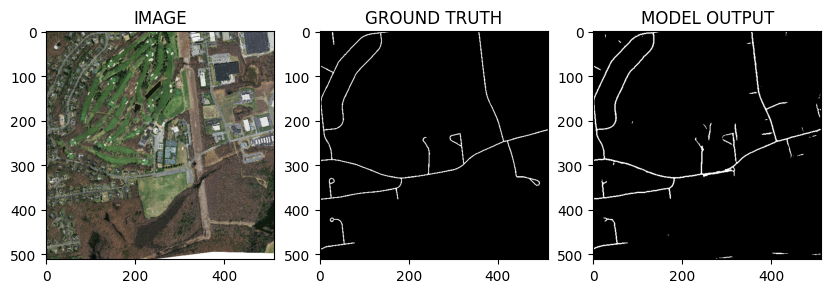

In [46]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

